# Exploring a Data Repository

<br>Owner: **Rob Morgan** ([@rmorgan10](https://github.com/LSSTScienceCollaborations/StackClub/issues/new?body=@rmorgan10)), **Phil Marshall** ([@drphilmarshall](https://github.com/LSSTScienceCollaborations/StackClub/issues/new?body=@drphilmarshall))
<br>Last Verified to Run: **2018-12-07**
<br>Verified Stack Release: **17.0**

This notebook shows how to find out what's in a data repository, and how to find out which inputs went into each component of it.  

### Learning Objectives:
After working through and studying this notebook you should be able to understand how to use the Butler to figure out: 
   1. What a data repo is;
   2. Which data types are present in a data repository;
   3. If coadds have been made, what the available tracts are;
   4. Which parts of the sky those tracts cover.
   
### Logistics
This notebook is intended to be runnable on `lsst-lsp-stable.ncsa.illinois.edu` from a local git clone of https://github.com/LSSTScienceCollaborations/StackClub.


## Set Up

In [1]:
import os
import sys
import warnings
import matplotlib.pyplot as plt
from IPython.display import display, Markdown
import numpy as np
import os, glob
%matplotlib inline

# Filter some warnings printed by v16.0 of the stack
# warnings.simplefilter("ignore", category=FutureWarning)
# warnings.simplefilter("ignore", category=UserWarning)

## What is a Data Repo?

Data repositories contain either a `_mapper` file or a `repositoryCfg.yaml` file, to record which "obs package" was used to organize the data. These files give a repository more strucutre and organization than an ordinary data directory. Let's take a look at this file structure in the HSC data repo.

### The HSC Data Repo: What's in there?

In [2]:
repo = '/datasets/hsc/repo'

We'll use the `hsc` data repository as our testing ground, and start by figuring out what it contains. In the `hsc` case, the `_mapper` file is in the top level folder, while the data repo for each field is a few levels down.

In [3]:
! ls /datasets/hsc/repo/

10NP2P31       DEEPE04	 DTH_A	     OBJECT		     SSP_DEEP_COSMOS
11NM5P21       DEEPE05	 FOCUS	     ON_AXIS_DOMEFLAT	     SSP_DEEP_DEEP2_3
ABELL2163      DEEPE06	 FOCUSING    ON_AXIS_DOMEFLAT_0DEG   SSP_DEEP_ELAIS_N1
algorithmData  DEEPE07	 GD153	     ON_AXIS_DOMEFLAT_72DEG  SSP_DEEP_XMM_LSS
BIAS	       DEEPE08	 HEL10_B     ON_AXIS_DOMEFLAT_90DEG  SSP_DEEP_XMMS_LSS
CALIB	       DEEPE09	 HEL30_I     R10		     SSP_UDEEP_COSMOS
CFHTLS_W1      DEEPE10	 HIP67394    ref_cats		     SSP_UDEEP_SXDS
COMET2014F3    DEN_A	 HIP67879    registry.sqlite3	     SSP_WIDE
COSMOS	       DEN_C	 M31	     rerun		     STRIPE82L
DARK	       DEN_E	 M31_N	     SDSS_CAL		     SXDS4HSCI2
deepCoadd      DITH_14H  M31_S	     SKYFLAT		     TEST
DEEPE01        DITH_16H  _mapper     SP01		     transmission
DEEPE02        DITH_D	 MOON_LIGHT  SR01
DEEPE03        DOMEFLAT  NAMERICA    SSP_AEGIS


We can see the `_mapper` file here, and at contains one line giving the name of the `Mapper` object for the HSC repo:

In [4]:
! cat /datasets/hsc/repo/_mapper

# Import the Mapper object once you know its name
from lsst.obs.hsc import HscMapper

lsst.obs.hsc.HscMapper


You can get some more information on this object like this:

In [5]:
# help(HscMapper)

The mapper defines a (large) number of different "dataset types". Some of these are specific to this particular data repo, others are more general. Even filtering out some intermediate dataset types, we are still left with a long list. But, once we figure out which dataset types we are interested in, we can start querying for information about those datasets.

In [6]:
mapper = HscMapper(root=repo)
all_dataset_types = mapper.getDatasetTypes()

remove = ['_config', '_filename', '_md', '_sub', '_len', '_schema', '_metadata']

shortlist = []
for dataset_type in all_dataset_types:
    keep = True
    for word in remove:
        if word in dataset_type:
            keep = False
    if keep:
        shortlist.append(dataset_type)

print(shortlist)

['bfKernel', 'bias', 'bias_camera', 'brightObjectMask', 'brighterFatterGain', 'brighterFatterKernel', 'calexp', 'calexpBackground', 'calexpThumb', 'calexp_bbox', 'calexp_calib', 'calexp_camera', 'calexp_detector', 'calexp_filter', 'calexp_visitInfo', 'calexp_wcs', 'calibrated_exp', 'calibrated_exp_bbox', 'calibrated_exp_calib', 'calibrated_exp_detector', 'calibrated_exp_filter', 'calibrated_exp_visitInfo', 'calibrated_exp_wcs', 'calibrated_src', 'camera', 'ccdExposureId', 'ccdExposureId_bits', 'coaddTempExp', 'coaddTempExp_bbox', 'coaddTempExp_calib', 'coaddTempExp_detector', 'coaddTempExp_filter', 'coaddTempExp_visitInfo', 'coaddTempExp_wcs', 'dark', 'dark_camera', 'dcor', 'dcor_bbox', 'dcor_calib', 'dcor_detector', 'dcor_filter', 'dcor_visitInfo', 'dcor_wcs', 'dcrCoadd', 'dcrCoaddId', 'dcrCoaddId_bits', 'dcrCoadd_bbox', 'dcrCoadd_calexp', 'dcrCoadd_calexp_background', 'dcrCoadd_calexp_bbox', 'dcrCoadd_calexp_calib', 'dcrCoadd_calexp_detector', 'dcrCoadd_calexp_filter', 'dcrCoadd_cale

The `Butler`, directed by the `Mapper` will have access to all the above dataset types. 

Another important file in the repo parent folder is `registry.sqlite3`. This database contains metadata for the HSC raw images.

### Great, but where's the actual data, and how was it made?

The raw visit images are stored by field. In the HSC dataset the fields have names like `COSMOS` and `DEEPE09`. Within those field folders, there is a directory structure that eventually gets down to visit image FITS files whose names and paths contain the date/time and filter for that exposure. For example:

In [7]:
! \ls /datasets/hsc/repo/COSMOS/2015-01-18/01113/HSC-Y/HSC-0018476-00?.fits

/datasets/hsc/repo/COSMOS/2015-01-18/01113/HSC-Y/HSC-0018476-000.fits
/datasets/hsc/repo/COSMOS/2015-01-18/01113/HSC-Y/HSC-0018476-001.fits
/datasets/hsc/repo/COSMOS/2015-01-18/01113/HSC-Y/HSC-0018476-002.fits
/datasets/hsc/repo/COSMOS/2015-01-18/01113/HSC-Y/HSC-0018476-003.fits
/datasets/hsc/repo/COSMOS/2015-01-18/01113/HSC-Y/HSC-0018476-004.fits
/datasets/hsc/repo/COSMOS/2015-01-18/01113/HSC-Y/HSC-0018476-005.fits
/datasets/hsc/repo/COSMOS/2015-01-18/01113/HSC-Y/HSC-0018476-006.fits
/datasets/hsc/repo/COSMOS/2015-01-18/01113/HSC-Y/HSC-0018476-007.fits
/datasets/hsc/repo/COSMOS/2015-01-18/01113/HSC-Y/HSC-0018476-008.fits
/datasets/hsc/repo/COSMOS/2015-01-18/01113/HSC-Y/HSC-0018476-009.fits


How do the pipeline tasks know which raw data to process? This information is captured in the "configs". In the HSC repo there is no config folder or files in the top level directory - in fact the only two files are `_mapper` and `registry.sqlite3`. So what's going on? 

It turns out that the provenance of the stack processing of the HSC raw images is captured in  "rerun" folders, one for each time the science pipelines were run on the data.  Let's do some detective work to find out what happened to the HSC data. 

In [8]:
! ls /datasets/hsc/repo/rerun

DM-10404  DM-13666  private  RC


First, `DM-10404` looks like a run ID. What's in that folder? 

In [9]:
! ls /datasets/hsc/repo/rerun/DM-10404

DEEP  logs  SFM  UDEEP	WIDE


`DEEP`, `WIDE`, and `UDEEP` are the names of the sub-surveys of the HSC survey. We might expect each to contain results from the processing of that sub-survey's images.

In [10]:
! ls /datasets/hsc/repo/rerun/DM-10404/UDEEP

00814  01004  01062  01172  01315  01327  01414		     repositoryCfg.yaml
00817  01052  01111  01174  01316  01378  config	     schema
00823  01055  01116  01179  01317  01382  deepCoadd
00991  01057  01122  01232  01318  01405  deepCoadd-results
00995  01059  01170  01236  01320  01407  jointcal-results


The numerically-names folders contain the generated catalog files, organized by sky tract. Note that a `config` folder is present, and also a `repositoryCfg.yaml` file - which means that this folder is itself a `repo`, from the Butler's point of view.

In [11]:
! cat /datasets/hsc/repo/rerun/DM-10404/WIDE/repositoryCfg.yaml

!RepositoryCfg_v1
_mapper: !!python/name:lsst.obs.hsc.hscMapper.HscMapper ''
_mapperArgs: null
_parents: [../SFM]
_policy: null
_root: null


What does it mean that `SFM` is the "parent" of this repo? Let's see what _that_ folder contains:

In [12]:
! ls /datasets/hsc/repo/rerun/DM-10404/SFM

00814  01052  01116  01183  01241  01297  01320  01407	    metadata
00817  01055  01122  01228  01288  01298  01327  01409	    repositoryCfg.yaml
00823  01057  01170  01230  01289  01299  01374  01411	    schema
00991  01058  01172  01232  01290  01315  01378  01413
00995  01059  01174  01234  01291  01316  01382  01414
01001  01062  01176  01236  01292  01317  01388  config
01004  01111  01179  01238  01296  01318  01405  deepCoadd


`SFM` seems to contain _all_ the tracts that have been produced - so is the entire HSC survey. It's `repositoryCfg.yaml` file shows that it's "parent" is the top level folder, `/datasets/hsc/repo/`.

In [13]:
! cat /datasets/hsc/repo/rerun/DM-10404/SFM/repositoryCfg.yaml

!RepositoryCfg_v1
_mapper: !!python/name:lsst.obs.hsc.hscMapper.HscMapper ''
_mapperArgs: null
_parents: [../../..]
_policy: null
_root: null


Let's see what the `DM-10404/UDEEP` repo's `config` folder contains:

In [14]:
! ls -a /datasets/hsc/repo/rerun/DM-10404/UDEEP/config

.   coaddDriver.py    mosaic.py		  packages.pickle
..  forcedPhotCcd.py  multiBandDriver.py


These are the configuration files that were used when the science pipelines were run on these data. While we don't know which versions of the software were used, we at least know which tasks were run. 

Notice that `ProcessCcd.py` is not in this list: re-runs can pick up the processing at any point, and just repeat a subset of the tasks. This is why the `parent` has to be recorded: in this case, information about the outputs of `ProcessCcd.py` should be available in the `parent` folder. 

> **PROBLEM: in the HSC dataset, there doesn't seem to be a config for the basic `ProcessCcd` image processing whose results must be somewhere in the top level (parent) folder. But where are these source tables? **

Here's what a config file looks like (ignoring the many import statements and just looking at a few example lines):

In [15]:
! cat /datasets/hsc/repo/rerun/DM-10404/UDEEP/config/forcedPhotCcd.py | grep -v import | head -15

assert type(config)==lsst.meas.base.forcedPhotCcd.ForcedPhotCcdConfig, 'config is of type %s.%s instead of lsst.meas.base.forcedPhotCcd.ForcedPhotCcdConfig' % (type(config).__module__, type(config).__name__)
# Run subtask to apply aperture corrections
config.doApCorr=True

# flux measurement algorithms in getApCorrNameSet() to ignore; if a name is listed that does not appear in getApCorrNameSet() then a warning is logged
config.applyApCorr.ignoreList=[]

# flux measurement algorithms to be aperture-corrected by reference to another algorithm; this is a mapping alg1:alg2, where 'alg1' is the algorithm being corrected, and 'alg2' is the algorithm supplying the corrections
config.applyApCorr.proxies={}

# set the general failure flag for a flux when it cannot be aperture-corrected?
config.applyApCorr.doFlagApCorrFailures=True

# coadd name: typically one of deep or goodSeeing
config.coaddName='deep'
grep: write error
cat: write error: Broken pipe


The next level to dig into here is the tract folders within one of the repos in this rerun. For example:

In [16]:
! ls /datasets/hsc/repo/rerun/DM-10404/UDEEP/00814/HSC-Y/tract9570 | head -10

forcedPhotCcd_metadata
FORCEDSRC-0000318-000.fits
FORCEDSRC-0000318-001.fits
FORCEDSRC-0000318-002.fits
FORCEDSRC-0000318-003.fits
FORCEDSRC-0000318-004.fits
FORCEDSRC-0000318-005.fits
FORCEDSRC-0000318-006.fits
FORCEDSRC-0000318-007.fits
FORCEDSRC-0000318-008.fits


Those FITS files contain the forced source tables.

## Instantiating the Butler and looking for Dataset Types

Now that we have an idea of the structure of the repo itself, let's use the Butler to explore the data within the repo. Here we will demonstrate a few useful `Butler` methods for learning about the data in a repo. Let's choose one of the rerun repos, and investigate its properties. We'll summon two butlers, one that is pointed at the parent repo, and another (an "under butler") that is asked to focus on a particular sub-survey in a particular re-run.

In [17]:
parent_repo = '/datasets/hsc/repo'

# Choose a re-run repo:
rerun_id = 'DM-10404'
depth = 'UDEEP'
# Try a different one:
# rerun = 'DM-13666'
# depth = 'WIDE'

repo = parent_repo + '/rerun/' + rerun_id + '/' + depth
print(repo)

from lsst.daf.persistence import Butler

butler = Butler(parent_repo)
under_butler = Butler(repo)

/datasets/hsc/repo/rerun/DM-10404/UDEEP


The `butler` purports to be able to check whether a datatype (like the source catalogs) actually exists or not, but it needs a specific dataset ID to check whether that specific part of the dataset exists. Here's what you get when you pass in a null dataset ID:

In [18]:
butler.datasetExists('src', dataId={})

False

Instead, one can try querying the repo metadata and checking for an error. Note that this way of checking for dataset existence is a little faster too.

Note that the metadata being queried here is in the `registry.sqlite3` database in the _parent_ repo - and so refers to the _initial_ processing run, not the most recent rerun. We'll need to work carefully around this below.

In [19]:
datasettype = 'src'

try:
    datasetkeys = butler.getKeys(datasettype)
    onekey = list(datasetkeys.keys())[0]
    metadata = butler.queryMetadata(datasettype, [onekey])
    print("{} dataset exists.".format(datasettype))
except:
    print("{} dataset doesn't exist.".format(datasettype))

src dataset exists.


So, even though its not at all obvious from the file system where the source catalog FITS files are, the `butler` knows where they are based on the metadata in the registry.

## Obtaining Basic Dataset Properties Using the Butler
Now we can start using Butler methods to query the data. For this dataset, we can look at the filters used, number of visits, number of pointings, etc. by examining the Butler's keys and metadata. For these basic properties, we will look at the `calexp` and `src` tables. The contents of these tables are derived from the processing of individual sensors, and exist in the parent folder. (That means that we can use either of our two butlers to query for them.)

In [20]:
# This would be faster if only one query were issued...
visits = butler.queryMetadata('calexp', ['visit'])
pointings = butler.queryMetadata('calexp', ['pointing'])
ccds = butler.queryMetadata('calexp', ['ccd'])
fields = butler.queryMetadata('calexp', ['field'])
filters = butler.queryMetadata('calexp', ['filter'])
sources = butler.queryMetadata('src', ['id'])

In [21]:
num_visits = len(visits)
num_pointings = len(pointings)
num_ccds = len(ccds)
num_fields = len(fields)
num_filters = len(filters)

num_sources = len(sources)

As a check, let's compare what our two butlers find when asked for the number of sources:

In [22]:
alt_num_sources = len(under_butler.queryMetadata('src', ['id']))

print("The butler says that we have {:d} sources.".format(num_sources)) 
print("The under butler says we have {:d} sources.".format(alt_num_sources))

The butler says that we have 1154258 sources.
The under butler says we have 1154258 sources.


So, we could have done our query with the `under_butler` as well. In practice, it's best to specify a Butler for the rerun repo, because that Butler will also have access to the parent repo.

One may also be interested in the total sky area imaged for a particular coadd rerun/depth. We can estimate and visualize this from the coadd tract info that neither our `under_butler` nor our `butler` has access to. To collect all the tracts, we have to get them via the file structure. This operation will hopefully be `Butler`-ized with the Gen3 Butler.

In [23]:
# Collect tract indices from file names
tracts = sorted([int(os.path.basename(x)) for x in
                 glob.glob(os.path.join(repo, 'deepCoadd-results', 'merged', '*'))])
num_tracts = len(tracts)

print("Found {} tracts in repo {}".format(num_tracts, repo))

Found 11 tracts in repo /datasets/hsc/repo/rerun/DM-10404/UDEEP


A quick way of extimating the sky area covered is to sum the areas of the inner boxes of all the tracts. For more information on the properties of tracts, you can look at the [Documentation](http://doxygen.lsst.codes/stack/doxygen/x_masterDoxyDoc/classlsst_1_1skymap_1_1tract_info_1_1_tract_info.html).

As a quick note, the file structure only tells us the names of the tracts in the particular rerun/depth to look at. The actual `TractInfo` objects are obtained by selecting the tracts we want from the `deepCoadd_skyMap` dataset in our particular rerun repo. Therefore, we will have to ask the `under_butler` to bring us this dataset for the particular rerun/depth. 

In [24]:
# Calculate area from all tracts
skyMap = under_butler.get('deepCoadd_skyMap')
total_area = 0.0  #deg^2
plotting_vertices = []
for test_tract in tracts:
    # Get inner vertices for tract
    tractInfo = skyMap[test_tract]
    vertices = tractInfo._vertexCoordList
    plotting_vertices.append(vertices)
    
    #calculate area of box
    av_dec = 0.5 * (vertices[2][1] + vertices[0][1])
    av_dec = av_dec.asRadians()
    delta_ra_raw = vertices[0][0] - vertices[1][0] 
    delta_ra = delta_ra_raw.asDegrees() * np.cos(av_dec)
    delta_dec= vertices[2][1] - vertices[0][1]
    area = delta_ra * delta_dec.asDegrees()
    
    #combine areas
    total_area += area
    

# Round off the total area for presentation purposes
rounded_total_area = round(total_area, 2)

print("Total area imaged (sq deg): ",rounded_total_area)

Total area imaged (sq deg):  31.04


In [25]:
print("The HSC {}/{} rerun contains {} visits.".format(rerun_id,depth,num_visits))
print("The HSC {}/{} rerun contains {} pointings.".format(rerun_id,depth,num_pointings))
print("The HSC {}/{} rerun contains {} ccds.".format(rerun_id,depth,num_ccds))
print("The HSC {}/{} rerun contains {} fields.".format(rerun_id,depth,num_fields))
print("The HSC {}/{} rerun contains {} filters.".format(rerun_id,depth,num_filters))
print("The HSC {}/{} rerun contains {} sources.".format(rerun_id,depth,num_sources))

The HSC DM-10404/UDEEP rerun contains 10333 visits.
The HSC DM-10404/UDEEP rerun contains 133 pointings.
The HSC DM-10404/UDEEP rerun contains 112 ccds.
The HSC DM-10404/UDEEP rerun contains 60 fields.
The HSC DM-10404/UDEEP rerun contains 13 filters.
The HSC DM-10404/UDEEP rerun contains 1154258 sources.


## Displaying Dataset Characteristics

Now let's print out a report of all the characteristcs we have found. We'll use the sky area from the rerun we chose, and the numbers common to all reruns.

In [26]:
dataset_name = 'HSC'
display(Markdown('### %s' % repo))


# Make a table of the collected metadata
collected_data = [num_visits, num_pointings, num_ccds, num_fields, num_filters, num_sources, 
                  num_tracts, rounded_total_area]
data_names = ("Number of Visits", "Number of Pointings", "Number of CCDs", "Number of Fields", 
              "Number of Filters", "Number of Sources", "Number of Tracts", "Total Sky Area (deg$^2$)")

output_table = "|   Metadata Characteristic  | Value | \n  | ---: | ---: | \n "
counter = 0
while counter < len(collected_data):
    output_table += "| %s |  %s | \n" %(data_names[counter], collected_data[counter])
    counter += 1
display(Markdown(output_table))

# Show which fields and filters we're talking about:
display(Markdown('Fields: (%i total)' %num_fields))
print(fields)
display(Markdown('Filters: (%i total)' %num_filters))
print(filters)


### /datasets/hsc/repo/rerun/DM-10404/UDEEP

|   Metadata Characteristic  | Value | 
  | ---: | ---: | 
 | Number of Visits |  10333 | 
| Number of Pointings |  133 | 
| Number of CCDs |  112 | 
| Number of Fields |  60 | 
| Number of Filters |  13 | 
| Number of Sources |  1154258 | 
| Number of Tracts |  11 | 
| Total Sky Area (deg$^2$) |  31.04 | 


Fields: (60 total)

['DOMEFLAT', 'DEN_E', 'BIAS', 'DEN_C', '10NP2P31', 'HEL30_I', 'MOON_LIGHT', 'COSMOS', 'DARK', 'HEL10_B', 'GD153', 'OBJECT', '11NM5P21', 'DEN_A', 'HIP67394', 'DITH_16H', 'ABELL2163', 'SKYFLAT', 'M31_N', 'M31_S', 'HIP67879', 'M31', 'NAMERICA', 'STRIPE82L', 'DITH_14H', 'CFHTLS_W1', 'DTH_A', 'FOCUS', 'SP01', 'DEEPE09', 'DITH_D', 'FOCUSING', 'DEEPE08', 'TEST', 'DEEPE02', 'DEEPE03', 'DEEPE06', 'DEEPE07', 'DEEPE01', 'COMET2014F3', 'DEEPE05', 'DEEPE10', 'DEEPE04', 'R10', 'SR01', 'SDSS_CAL', 'SSP_WIDE', 'SSP_UDEEP_SXDS', 'SSP_UDEEP_COSMOS', 'ON_AXIS_DOMEFLAT_90DEG', 'SSP_DEEP_DEEP2_3', 'ON_AXIS_DOMEFLAT_0DEG', 'SSP_AEGIS', 'SSP_DEEP_COSMOS', 'SSP_DEEP_ELAIS_N1', 'SSP_DEEP_XMM_LSS', 'SSP_DEEP_XMMS_LSS', 'ON_AXIS_DOMEFLAT', 'ON_AXIS_DOMEFLAT_72DEG', 'SXDS4HSCI2']


Filters: (13 total)

['HSC-Z', 'HSC-G', 'ENG-R1', '109', 'HSC-I', 'NB0921', 'HSC-R', 'SH', 'HSC-Y', 'NB0816', 'NB0656', 'HSC-I2', 'NB0515']


## Plotting the sky coverage

For this we will need our list of `tracts` from above, and also the `skyMap` object. We can then extract the sky coordinates of the corners of each tract, and use them to draw a set of rectangles to illustrate the sky coverage, following Jim Chiang's LSST DESC tutorial [dm_butler_skymap.ipynb](https://github.com/LSSTDESC/DC2-analysis/blob/master/tutorials/dm_butler_skymap.ipynb).

In the future, we could imagine overlaying the focal plane and color the individual visits, using more of the code from Jim's notebook. Let's see what functionality the Gen3 Butler provides first, and then return to visualization.

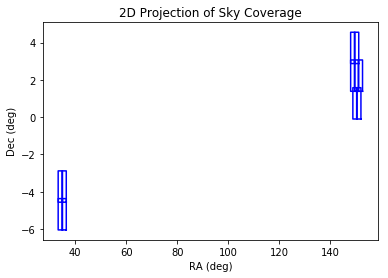

In [27]:
plt.figure()

for tract in tracts:
    tractInfo = skyMap[tract]
        
    corners = [(x[0].asDegrees(), x[1].asDegrees()) for x in tractInfo.getVertexList()]
    x = [k[0] for k in corners] + [corners[0][0]]
    y = [k[1] for k in corners] + [corners[0][1]]
    
       
    plt.plot(x,y, color='b')
    
plt.xlabel('RA (deg)')
plt.ylabel('Dec (deg)')
plt.title('2D Projection of Sky Coverage')

plt.show()

We could imagine plotting the patches as well, to show which tracts were incomplete - but this gives us a rough idea of where our data is on the sky.

# Summary

We have shown a few techniques for exploring a data repo. To make this process straightforward, we have implemented all these techniques into mehtods of a `Taster` class, which is now a part of the `stackclub` library. The `Taster` will give you a taste of what the `Butler` delivers. we demonstrate the use of this class in the [DataInventory.ipynb](https://github.com/LSSTScienceCollaborations/StackClub/blob/project/data_inventory/drphilmarshall/Basics/DataInventory.ipynb) notebook.
